In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import pickle

import pandas as pd

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Layer
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import keras.backend as K

from vae_utils import *

Using TensorFlow backend.


In [4]:
diag = lambda x: np.diag(np.diag(x))

In [5]:
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{bm},\usepackage{amsmath},\usepackage{amssymb}"

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 9
plt.rcParams["legend.fontsize"] = 8

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = 3.2, 1.98

# 2. Method

## 2.1 Series Expansion

In [5]:
def logZ_expansion(expectation, variance, lamb=1):
    return -lamb * expectation + lamb**2 / 2 * variance

## 2.2 Analytic Method (PPCA)

In [6]:
def expectation_V(x, W, b, sigma, method='matmul'):
    # the method keyword specifies whether to use tensordot or matmul to calcuate log_p_x
    # tensordot is faster, but does not do elementwise operations, so you lose info over x
    # matmul is slower, but is elementwise for x
    d, l = W.shape
    N = len(x)
    M = matmul(W.T, W) + sigma * eye(l)
    C = matmul(W, W.T) + sigma * eye(d)
    
    if method == 'matmul':
        log_p_x = -1/2 * linalg.slogdet(2 * pi * C)[1] - 1/2 * matmul(matmul((x-b).transpose(0, 2, 1), inv(C)), x-b)
    elif method == 'tensordot':
        log_p_x = -1/2 * linalg.slogdet(2 * pi * C)[1] - 1/(2*N) * tensordot(matmul((x[:,:,0]-b[:,0]), inv(C)), x[:,:,0]-b[:,0])
    
    elbo = log_p_x - 1/2 * linalg.slogdet(diag(M))[1] + 1/2 * linalg.slogdet(M)[1]
    
    return -elbo

def variance_V(W, sigma):
    d, l = W.shape
    M = matmul(W.T, W) + sigma * eye(l)
    inner = linalg.matrix_power(matmul(M-diag(M), inv(diag(M))), 2)
    return 1/2 * trace(inner)

In [282]:
def calculate_W_sigma(x, S, l=2):
    # find the eigs and eigenvectors of the cov matrix and sort according
    eigs, evecs = linalg.eig(S)
    eig_pairs = list(zip(eigs, evecs.T))
    eig_pairs.sort(reverse=True, key=lambda x: x[0])

    # select the top q principle components
    d = len(eig_pairs)

    pca_pairs = eig_pairs[:l]
    
    pca_eigs = [pca_pairs[i][0] for i in range(len(pca_pairs))]
    pca_vecs = [pca_pairs[i][1] for i in range(len(pca_pairs))]

    # construct W and sigma^2
    L_q = np.diag(pca_eigs)
    U_q = array(pca_vecs).T
    sigma = 1/(d-l) * np.sum([eig_pairs[j][0] for j in range(l+1, d)]) #technically inverse sigma
    W = np.matmul(U_q, L_q - sigma * eye(l))
    return W, sigma
    
def calculate_elbo(x, W, sigma, R=None, method='tensordot'):
    # find shape of W
    d, l = W.shape
    N = len(x)
    
    # find the mean of x
    b = np.mean(x, axis=0)
    
    # rotate W if it is a 2d matrix
    if R is not None:
        W = matmul(W, R)
#     if l == 2:
#         R = np.array([
#             [cos(theta), -sin(theta)],
#             [sin(theta), cos(theta)]
#         ])
#         W = matmul(W, R)
#     if l == 3:
# #         R = np.array([
# #             [cos(theta), -sin(theta), 0],
# #             [sin(theta), cos(theta), 0],
# #             [0, 0, 1]
# #         ])
#         R = np.array([
#             [1, 0, 0],
#             [0, cos(theta), -sin(theta)],
#             [0, sin(theta), cos(theta)]
#         ])
#         W = matmul(W, R)

    # find p(z|x)
    M = matmul(W.T, W) + sigma * eye(l)
    p_z_x_mu = matmul(matmul(inv(M), W.T), (x-b))
    p_z_x_sig = sigma * inv(M)

    # find best q(z|x)
    q_z_x_mu = matmul(matmul(inv(M), W.T), (x-b))
    q_z_x_sig = sigma * inv(diag(M))

    # find p(x)
    p_x_mu = b
    p_x_sig = matmul(W, W.T) + sigma * eye(d)
    inv_p = inv(p_x_sig)

    # find p(x|z)
    p_x_z_mu = lambda z: matmul(W, z.T).T + b
    p_x_z_sig = sigma * eye(d)

    # calculate log p(x)
    detsign, detlog = linalg.slogdet(2*pi*p_x_sig)
    if method == 'matmul':
        log_p_x = -1/2 * detlog - 1/2 * matmul(matmul((x-p_x_mu).transpose(0, 2, 1), inv_p), x-p_x_mu)
    elif method == 'tensordot':
        log_p_x = -1/2 * detlog - 1/(2*N) * tensordot(matmul(x[:,:,0]-p_x_mu[:,0], inv_p), x[:,:,0]-p_x_mu[:,0])
    log_p_x_mean = np.mean(log_p_x)

    # # calculate the elbo stochastically
    # z_samples = q_z_x_mu + np.expand_dims(random.multivariate_normal(zeros(l), q_z_x_sig, size=len(q_z_x_mu)), -1)
    # x_z_mu = p_x_z_mu(z_samples)

    # log_p = lambda x, mu, sig: -1/2 * linalg.slogdet(2*pi*sig)[1] - 1/2 * matmul(matmul((x-mu).transpose(0, 2, 1), inv(sig)), x-mu)
    # log_p_x_z = log_p(x, x_z_mu, p_x_z_sig)
    # log_p_z = log_p(z_samples, zeros((l, 1)), eye(l))
    # log_q_z_x = log_p(z_samples, q_z_x_mu, q_z_x_sig)

    # pca_elbo = log_p_x_z + log_p_z - log_q_z_x
    # pca_elbo_mean = np.mean(pca_elbo)

    # calculate the elbo analytically
    elbo = log_p_x - 1/2 * linalg.slogdet(diag(M))[1] + 1/2 * linalg.slogdet(M)[1]
    elbo_mean = np.mean(elbo)
    
    # calculate the variance analytically
    variance = variance_V(W, sigma)
    
    return log_p_x_mean, elbo_mean, variance

## 2.3 Neural Network

In [6]:
def encoder(latent_dim, hidden_dim=200):
    enc_in = Input(shape=(784,1), name='enc_input')
    enc_flat = Flatten(name='enc_flat')(enc_in)
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')(enc_flat)
    enc_hid2 = Dense(hidden_dim, activation='relu', name='enc_hidden2')(enc_hid)
    z_mean = Dense(latent_dim, name='latent_mean')(enc_hid2)
    log_z_var = Dense(latent_dim, name='log_latent_var')(enc_hid2)
    enc_model = Model(enc_in, [z_mean, log_z_var], name='encoder_model')
    return enc_model, (z_mean, log_z_var)

def decoder(latent_dim, hidden_dim=200, model='bernoulli'):
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')(dec_in)
    dec_hid2 = Dense(hidden_dim, activation='relu', name='dec_hidden2')(dec_hid)
    dec_out = Dense(28*28, activation='sigmoid', name='dec_flat')(dec_hid2)
    dec_out = Reshape((784, 1), name='dec_out')(dec_out)
    dec_model = Model(dec_in, dec_out, name='decoder_model')
    return dec_model

In [7]:
class Sampler(Layer):
    
    def __init__(self, always_sample=False, **kwargs):
        self.always_sample = always_sample
        super(Sampler, self).__init__(**kwargs)
    
    def call(self, x, training=None):
        assert isinstance(x, list)
        z_mean, log_z_var = x
        z_std = K.exp(log_z_var/2)
        
        # sample epsilon from N(0, stddev)
        shape = K.shape(z_mean)
        epsilon = K.random_normal(shape, mean=0, stddev=1)
        z_sample = z_mean + z_std * epsilon
        
        if self.always_sample:
            return z_sample
        else:
            return K.in_train_phase(z_sample, z_mean, training=training)
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return input_shape[0]

In [8]:
def bernoulli_elbo(y_true, y_pred):
    kl_loss = 0.5 * np.sum(1 + log_z_var - np.square(z_mean) - np.exp(log_z_var), axis=-1)
    im_loss = np.sum(y_true * np.log(y_pred + 1e-30) + (1-y_true) * np.log(1-y_pred + 1e-30), axis=(-1, -2))
    return kl_loss + im_loss

# 3. Results

## 3.1. Data

### 3.1.1. Generated

In [9]:
# generate data
mean = zeros(5)
S_gen = 1/2 * array([
    [1, 0.9, 0.8, 0.7, 0.6],
    [0, 1, 0.9, 0.8, 0.7],
    [0, 0, 1, 0.9, 0.8],
    [0, 0, 0, 1, 0.9],
    [0, 0, 0, 0, 1]
])
S_gen = S_gen + S_gen.T
x_gen = np.random.multivariate_normal(mean, S_gen, size=(60000,))
x_gen = np.expand_dims(x_gen, -1)

### 3.1.2. MNIST

In [10]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 784))
    x = x/255.
    x = np.expand_dims(x, -1)
    #y = to_categorical(y, 10) # don't need to categorise y
    return x, y

train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

if not os.path.exists('./S.npy'):
    b = np.mean(x_train, axis=0)
    S = 0
    for x in x_train:
        S+= np.outer(x-b, x-b)
    S /= len(x_train)
    np.save('./S.npy', S)

S = np.load('./S.npy')

## 3.2. Analytic Model

### 3.2.1. Result 1
Sweep $W_{ML}$ for $\ell=2$ and show that the ELBO is maximsied for an orthogonal $\mathbf{M}$ on a _generated dataset_.

In [215]:
W_gen, sigma_gen = calculate_W_sigma(x_gen, S_gen, l=2)

alpha = linspace(0, pi, 100)
rotate_2 = lambda theta: array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
generated_elbos = array([calculate_elbo(x_gen, W_gen, sigma_gen, R=rotate_2(a)) for a in alpha])

log_p_x_gen = generated_elbos[:, 0]
elbo_gen = generated_elbos[:, 1]
var_gen = generated_elbos[:, 2]
second_gen = elbo_gen + 1/2 * var_gen

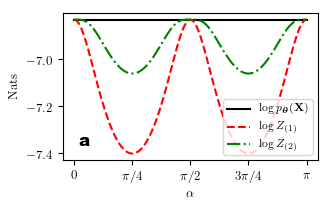

In [216]:
plot(theta, log_p_x_gen, '-k', label=r'$\log p_{\bm{\theta}}(\mathbf{X})$')
plot(theta, elbo_gen, '--r', label=r'$\log Z_{(1)}$')
plot(theta, second_gen, '-.g', label=r'$\log Z_{(2)}$')

legend(loc=4)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

ylabel(r'Nats')

text(0.1/1.618, 0.1, 'a',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

savefig('./Figures/generated_logZ_v_theta_l02.pdf')

### 3.2.2. Result 2
Sweep $W_{ML}$ for $\ell=2$ and show that the ELBO is maximsied for an orthogonal $\mathbf{M}$ on the _MNIST dataset_.

In [217]:
W, sigma = calculate_W_sigma(x_train, S, l=2)

alpha = linspace(0, pi, 100)
rotate_2 = lambda theta: array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
mnist_elbos = array([calculate_elbo(x_train, W, sigma, R=rotate_2(a)) for a in alpha])

log_p_x_mnist = mnist_elbos[:, 0]
elbo_mnist = mnist_elbos[:, 1]
var_mnist = mnist_elbos[:, 2]
second_mnist = elbo_mnist + 1/2 * var_mnist

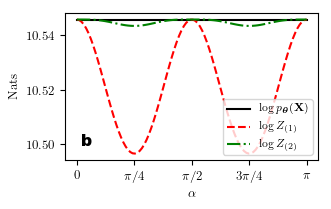

In [218]:
plot(theta, log_p_x_mnist, '-k', label=r'$\log p_{\bm{\theta}}(\mathbf{X})$')
plot(theta, elbo_mnist, '--r', label=r'$\log Z_{(1)}$')
plot(theta, second_mnist, '-.g', label=r'$\log Z_{(2)}$')

legend(loc=4)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

ylabel(r'Nats')

text(0.1/1.618, 0.1, 'b',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

gcf().savefig('./Figures/mnist_logZ_v_theta_l02.pdf')

### 3.2.3. Result 3
Comparing second order t=correct term between MNIST and the gneerated set.

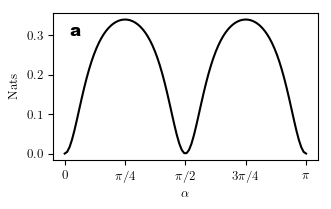

In [328]:
plot(theta, 1/2 * var_gen, '-k', label='Generated')

# legend(loc=1)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

text(0.1/1.618, 0.85, 'a',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

ylabel(r'Nats')

gcf().savefig('./Figures/generated_var_l02.pdf')

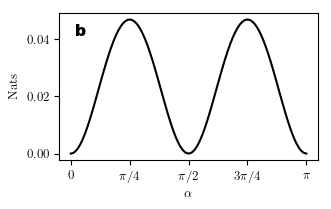

In [329]:
plot(theta, 1/2 * var_mnist, '-k', label='MNIST')
# plot(theta, var_gen, '-.b', label='Generated')

# legend(loc=1)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

text(0.1/1.618, 0.85, 'b',
     fontdict = {
         'family': 'sans-serif',
         'name': 'arial',
         'size': 12,
         'weight': 'black',
         'usetex': False
     },
     transform=gca().transAxes
)

ylabel(r'Nats')

gcf().savefig('./Figures/mnist_var_l02.pdf')

### 3.2.4 Result 4
Sweeping $\mathbf{W}_{ML}$ over non-leading PCA axes.

Text(0, 0.5, 'Nats')

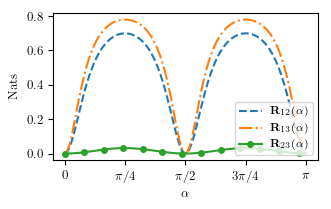

In [311]:
W_gen, sigma_gen = calculate_W_sigma(x_gen, S_gen, l=3)

rotate_3_12 = lambda theta: array([[cos(theta), -sin(theta), 0], [sin(theta), cos(theta), 0], [0, 0, 1]])
rotate_3_13 = lambda theta: array([[cos(theta), 0, -sin(theta)], [0, 1, 0], [sin(theta), 0, cos(theta)]])
rotate_3_23 = lambda theta: array([[1, 0, 0], [0, cos(theta), -sin(theta)], [0, sin(theta), cos(theta)]])
rotates = [rotate_3_12, rotate_3_13, rotate_3_23]
labels = ['12', '13', '23']
styles = ['--', '-.', '-o']

alpha = linspace(0, pi, 100)

log_p_x_rot, _, _ = calculate_elbo(x_gen, W_gen, sigma_gen)
plot(alpha, [log_p_x_rot] * len(alpha), '-k', label = r'$\log p_{\bm{\theta}}(\mathbf{X})$')

for i, rotate in enumerate(rotates):
    rotated_elbos = array([calculate_elbo(x_gen, W_gen, sigma_gen, R=rotate(a)) for a in alpha])

    log_p_x_rot = rotated_elbos[:, 0]
    elbo_rot = rotated_elbos[:, 1]
    var_rot = rotated_elbos[:, 2]
    second_rot = elbo_rot + 1/2 * var_rot
    
    plot(alpha, second_rot, styles[i], label = r'$\mathbf{R}_{%s}(\alpha)$' %labels[i], markevery=8, ms=4)
    
legend(loc=4)

xticks((0, pi/4, pi/2, 3*pi/4, pi), labels=(r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'))
xlabel(r'$\alpha$')

ylabel(r'Nats')

## 3.3 Neural Network

In [74]:
def binarize_generator(x, batch_size, shuffle=True):
    x = np.random.permutation(x) if shuffle else x
    nb_batch = 0
    
    while True:
        batch = x[nb_batch*batch_size:(nb_batch+1)*batch_size]
        y = np.random.binomial(n=1, p=batch)
        
        nb_batch += 1
        if nb_batch >= np.ceil(len(x) / batch_size):
            x = np.random.permutation(x) if shuffle else x
            nb_batch = 0
            
        yield y, y

In [73]:
latent_dim = 50

encoder_model, (z_mean, log_z_var) = encoder(latent_dim)
decoder_model = decoder(latent_dim)
z_sampler = Sampler(always_sample=True, name='z_sampler')([z_mean, log_z_var])

vae_model = Model(encoder_model.input, decoder_model(z_sampler))

def bernoulli_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.sum(1 + log_z_var - K.square(z_mean) - K.exp(log_z_var), axis=-1)
    im_loss = K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2)) # computes -log p(x|z)
    return kl_loss + im_loss

vae_model.compile(optimizer='adam', loss=bernoulli_loss)

# train and save the model

if not os.path.exists('./models/'):
    os.mkdir('./models')

dec_path = './models/dec_model_%d_dim.weights' %latent_dim
weights_path = './models/vae_model_%d_dim.weights' %latent_dim
history_path = './models/history_%d_dim.pkl' %latent_dim

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=10**(-1/7), patience=10, min_lr=1e-4, verbose=1)
nb_regions = 7
regions = cumsum([3**i for i in range(nb_regions+1)])
schedule = lambda i, lr: 0.001 * 10**(-sum(regions <= i)/nb_regions)

lr_schedule = LearningRateScheduler(schedule)
# early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)

epochs = regions[-1]
batch_size = 512
steps_per_epoch = np.ceil(len(x_train) / batch_size)

if not os.path.exists(weights_path):
    # training
    history = vae_model.fit_generator(
        binarize_generator(np.random.binomial(n=1, p=x_train), batch_size),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[lr_schedule]
    )
    # enc_dec_model represents the whole dec_model as a single layer
    # so we have to save the decoder weights seperately
    decoder_model.save_weights(dec_path) # hacky fix for decoder weights
    vae_model.save_weights(weights_path)
    # save history
    history = history.history
    pickle.dump(history, open(history_path, 'wb'))
    print('Model Saved')
else:
    decoder_model.load_weights(dec_path, by_name=True)
    encoder_model.load_weights(weights_path, by_name=True)
    vae_model.load_weights(weights_path, by_name=True)
    history = pickle.load(open(history_path, 'rb'))
    print('Model Loaded')

Epoch 1/50
118/118 [==============================] - 4s 34ms/step - loss: 232.7215
Epoch 2/50
118/118 [==============================] - 3s 23ms/step - loss: 179.1726
Epoch 3/50
118/118 [==============================] - 3s 24ms/step - loss: 160.8128
Epoch 4/50
118/118 [==============================] - 3s 23ms/step - loss: 149.0393
Epoch 5/50
118/118 [==============================] - 3s 24ms/step - loss: 141.1374
Epoch 6/50
118/118 [==============================] - 3s 28ms/step - loss: 136.1183
Epoch 7/50
118/118 [==============================] - 4s 37ms/step - loss: 131.8347
Epoch 8/50
118/118 [==============================] - 4s 37ms/step - loss: 128.1797
Epoch 9/50
118/118 [==============================] - 4s 36ms/step - loss: 125.2459
Epoch 10/50
118/118 [==============================] - 4s 36ms/step - loss: 122.6846
Epoch 11/50
118/118 [==============================] - 4s 37ms/step - loss: 120.4737
Epoch 12/50
118/118 [==============================] - 4s 36ms/step - loss

In [29]:
z_mean, log_z_var = encoder_model.predict(x_train)

In [30]:
nb_samples = 10
x_preds = array([vae_model.predict(x_train, batch_size=2000) for n in range(nb_samples)])
elbos = bernoulli_elbo(x_train, x_preds)

In [31]:
np.mean(np.var(elbos, axis=0))

12.088214938934865

In [32]:
np.mean(np.mean(elbos, axis=0) + 1/2 * np.var(elbos, axis=0))

-89.26239441175099

In [21]:
np.var(elbos, axis=0)

array([18.0935425 , 13.43378941, 30.91659184, ..., 17.27027474,
       12.67180452, 17.61038191])

In [ ]:
np.mean(elbos, axis=(0, 1))

In [22]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          (None, 784, 1)       0                                            
__________________________________________________________________________________________________
enc_flat (Flatten)              (None, 784)          0           enc_input[0][0]                  
__________________________________________________________________________________________________
enc_hidden (Dense)              (None, 200)          157000      enc_flat[0][0]                   
__________________________________________________________________________________________________
enc_hidden2 (Dense)             (None, 200)          40200       enc_hidden[0][0]                 
__________________________________________________________________________________________________
latent_mea